# Data exploration

A key part of Data Science is interactive exploration of your dataset. There are arguably many tools to perform data science, but [Python Pandas](https://pandas.pydata.org/) is one of the most widely used. Even with recent developments, Pandas is known to struggle with performance when dealing with demanding datasets, so in the past few years the [Polars project](https://pola.rs/) has become very popular. This notebook explores very basic interactive exploration using both Pandas and Polars, and also with a less known but also cool library, [Facets](https://github.com/PAIR-code/facets).

## Data exploration using Pandas

In [1]:
#This line is needed to display the charts later in the notebook
%matplotlib widget 
#ignore deprecation warnings in this demo
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

import os

# Fetch environment variables with defaults
host = os.getenv('QDB_CLIENT_HOST', 'questdb')
port = os.getenv('QDB_CLIENT_PORT', '8812')
user = os.getenv('QDB_CLIENT_USER', 'admin')
password = os.getenv('QDB_CLIENT_PASSWORD', 'quest')

# Create the connection string using the environment variables or defaults
conn_str = f'user={user} password={password} host={host} port={port} dbname=qdb'

# Database connection details
db_config = {
    'user': user,
    'password': password,
    'host': host,
    'port': port, 
    'database': 'qdb'
}

# Create a database connection
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')
query = 'SELECT * FROM github_events'


df = pd.read_sql(query, engine)

# Display the first few rows of the DataFrame
df.head()

repo              type  \
0                 AadityaJain17/jobgenie       CreateEvent   
1  trafver54336457645/trafver54336457645         PushEvent   
2                   goofysun/Get-IP-SELF         PushEvent   
3       kakao-travel-mandi/mandi-backend  PullRequestEvent   
4           integration-os/integrationos         PushEvent   

                 actor                  timestamp  
0        AadityaJain17 2024-09-24 17:25:58.179036  
1  github-actions[bot] 2024-09-24 17:25:58.181431  
2  github-actions[bot] 2024-09-24 17:25:58.181474  
3           LEE-sh1673 2024-09-24 17:25:58.181521  
4               paulkr 2024-09-24 17:25:58.181549

In [43]:
# Check the data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   repo       13860 non-null  object        
 1   type       13860 non-null  object        
 2   actor      13860 non-null  object        
 3   timestamp  13860 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 433.3+ KB


In [137]:
# Summary statistics of numerical columns
df.describe()

timestamp
count                          11730
mean   2024-01-30 12:37:41.430206720
min       2024-01-30 12:03:24.127240
25%    2024-01-30 12:20:28.558031872
50%    2024-01-30 12:37:41.578468864
75%    2024-01-30 12:54:54.929385216
max       2024-01-30 13:11:56.653242

In [110]:
# Count unique values in categorical columns
df['type'].value_counts()

type
PushEvent                        6644
CreateEvent                       690
PullRequestEvent                  419
IssueCommentEvent                 265
WatchEvent                        232
PullRequestReviewEvent            205
DeleteEvent                       180
IssuesEvent                       113
PullRequestReviewCommentEvent      91
ForkEvent                          81
ReleaseEvent                       35
MemberEvent                        19
PublicEvent                        15
CommitCommentEvent                  6
GollumEvent                         5
Name: count, dtype: int64

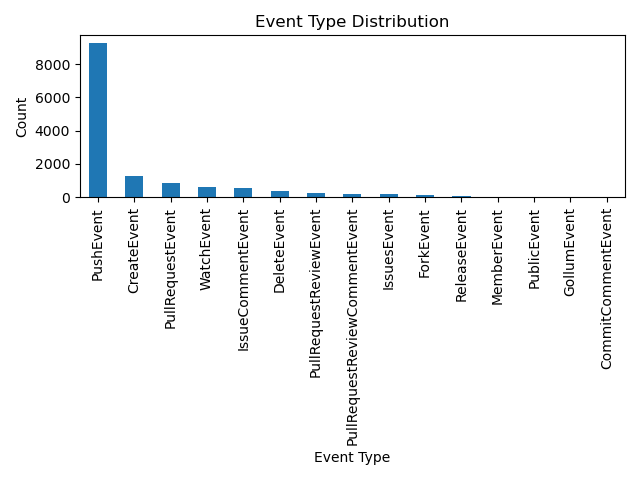

In [44]:
# Plot a bar chart for categorical columns
plt.figure()  # Create another new figure object
df['type'].value_counts().plot(kind='bar')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.title('Event Type Distribution')
plt.tight_layout()
plt.show()  # Display the plot


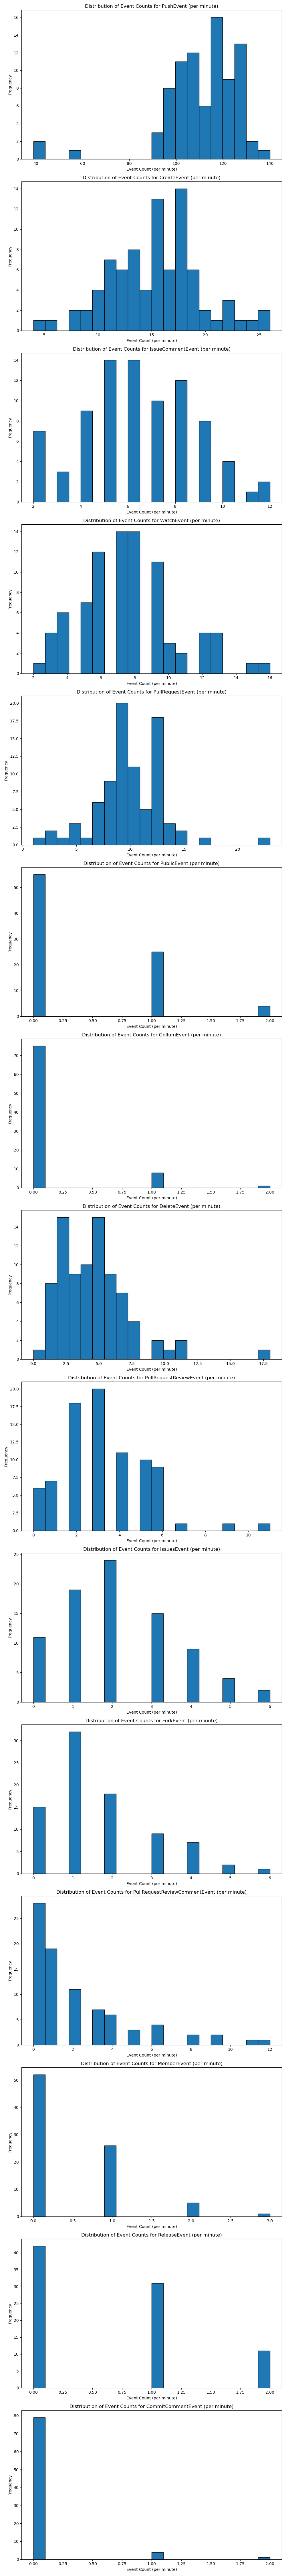

In [45]:
# Group the DataFrame by minute intervals and event types
grouped = df.groupby([pd.Grouper(key='timestamp', freq='1Min'), 'type']).size().unstack(fill_value=0)

# Get unique event types
unique_event_types = df['type'].unique()

# Create subplots for each event type
fig, axes = plt.subplots(nrows=len(unique_event_types), figsize=(10, 6 * len(unique_event_types)))

for i, event_type in enumerate(unique_event_types):
    ax = axes[i]
    
    # Create a histogram for the event count of the current type
    ax.hist(grouped[event_type], bins=20, edgecolor='k')
    ax.set_xlabel('Event Count (per minute)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Event Counts for {event_type} (per minute)')

plt.tight_layout()
plt.show()


In [6]:
# polars is not included on the jupyter notebook docker image, so we need to install it
!pip install polars

In [10]:
import polars as pl
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Database connection details
db_config = {
    'user': 'admin',
    'password': 'quest',
    'host': 'questdb',
    'port': 8812,
    'database': 'qdb'
}

# Create a database connection string
connection_str = f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}'

# Create a SQLAlchemy engine
engine = create_engine(connection_str)

# Define your SQL query
query = 'SELECT * FROM github_events'

# Execute the query and fetch data into a pandas DataFrame
df = pd.read_sql(query, engine)

# Convert the pandas DataFrame to a Polars DataFrame
df_polars = pl.DataFrame(df)

# Display the first few rows of the Polars DataFrame
print(df_polars.head())

# Check the schema of the Polars DataFrame
print(df_polars.schema)




shape: (5, 4)
┌─────────────────────────────┬─────────────┬─────────────┬────────────────────────────┐
│ repo                        ┆ type        ┆ actor       ┆ timestamp                  │
│ ---                         ┆ ---         ┆ ---         ┆ ---                        │
│ str                         ┆ str         ┆ str         ┆ datetime[ns]               │
╞═════════════════════════════╪═════════════╪═════════════╪════════════════════════════╡
│ cs-jsi/chisel4ml            ┆ PushEvent   ┆ jurevreca12 ┆ 2024-02-02 08:05:12.023344 │
│ Tarzan22/BES-Backend        ┆ CreateEvent ┆ Tarzan22    ┆ 2024-02-02 08:05:12.026647 │
│ haoqing0110/addon-framework ┆ CreateEvent ┆ haoqing0110 ┆ 2024-02-02 08:05:12.026703 │
│ negoxa2020/web_individ      ┆ PushEvent   ┆ negoxa2020  ┆ 2024-02-02 08:05:12.026730 │
│ estevenson9/sketch          ┆ PushEvent   ┆ estevenson9 ┆ 2024-02-02 08:05:12.026751 │
└─────────────────────────────┴─────────────┴─────────────┴────────────────────────────┘
Ordered

In [15]:
# Check the data types and null values
df.describe()

timestamp
count                           5160
mean   2024-02-02 08:20:29.363307008
min       2024-02-02 08:05:12.023344
25%    2024-02-02 08:12:57.798562560
50%    2024-02-02 08:20:31.040339456
75%    2024-02-02 08:28:04.566559488
max       2024-02-02 08:35:37.167323

In [38]:
df

repo         type  \
0                                      cs-jsi/chisel4ml    PushEvent   
1                                  Tarzan22/BES-Backend  CreateEvent   
2                           haoqing0110/addon-framework  CreateEvent   
3                                negoxa2020/web_individ    PushEvent   
4                                    estevenson9/sketch    PushEvent   
...                                                 ...          ...   
5155                                      235wgdf/repo5    PushEvent   
5156                                       biqute/qtics  DeleteEvent   
5157                Samriddhi-Sardar/Audiobook-for-kids  CreateEvent   
5158  NumtraCG/65bc946c644fb26e5dd63f3720240202-0827...  CreateEvent   
5159                          ClaudiiaGutierrez/TASCA-4  CreateEvent   

                  actor                  timestamp  
0           jurevreca12 2024-02-02 08:05:12.023344  
1              Tarzan22 2024-02-02 08:05:12.026647  
2           haoqing0110 2024-02-02 08:05:12.026703  
3            negoxa2020 2024-02-02 08:05:12.026730  
4           estevenson9 2024-02-02 08:05:12.026751  
...                 ...                        ...  
5155          ttgds3asu 2024-02-02 08:35:37.167318  
5156    rodolfocarobene 2024-02-02 08:35:37.167320  
5157   Samriddhi-Sardar 2024-02-02 08:35:37.167321  
5158           NumtraCG 2024-02-02 08:35:37.167322  
5159  ClaudiiaGutierrez 2024-02-02 08:35:37.167323  

[5160 rows x 4 columns]

In [40]:
# Count unique values in categorical columns
event_counts = df.groupby('type').count()
event_counts


repo  actor  timestamp
type                                                 
CommitCommentEvent                1      1          1
CreateEvent                     479    479        479
DeleteEvent                     168    168        168
ForkEvent                        48     48         48
GollumEvent                       4      4          4
IssueCommentEvent               199    199        199
IssuesEvent                      58     58         58
MemberEvent                      17     17         17
PublicEvent                      19     19         19
PullRequestEvent                308    308        308
PullRequestReviewCommentEvent    56     56         56
PullRequestReviewEvent           95     95         95
PushEvent                      3467   3467       3467
ReleaseEvent                     20     20         20
WatchEvent                      221    221        221

In [41]:
# Count unique values in categorical columns
df.groupby('type').value_counts()

type                repo                                            actor             timestamp                 
CommitCommentEvent  symious/ratis                                   symious           2024-02-02 08:23:46.779590    1
CreateEvent         12deeksha/exp1                                  12deeksha         2024-02-02 08:13:53.388973    1
                    Udaytas/test1                                   Udaytas           2024-02-02 08:33:19.601644    1
                    clalit-genomics/variant_calling_benchmarker     oferisak          2024-02-02 08:19:00.777596    1
                    charlotte-bourny/projet-hackaton-2              charlotte-bourny  2024-02-02 08:20:46.965305    1
                                                                                                                   ..
WatchEvent          CYBER-x-SACHIYA-SL-MD-BOT/CYBER-PANDA-MD.V.0.4  shubhamkukreja12  2024-02-02 08:22:53.949181    1
                    CTradeExchange/free-forex-market-data    

## Exploration using specialized libraries, like Facets


In [10]:
# polars is not included on the jupyter notebook docker image, so we need to install it

!pip install facets-overview

In [13]:
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from sqlalchemy import create_engine
import pandas as pd
from IPython.core.display import display, HTML
import base64

# Database connection details
db_config = {
    'user': 'admin',
    'password': 'quest',
    'host': 'questdb',
    'port': 8812, 
    'database': 'qdb'
}

# Create a database connection
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')
query = 'SELECT * FROM github_events '

# Execute the query and fetch data into a DataFrame
df = pd.read_sql(query, engine)
proto = GenericFeatureStatisticsGenerator().ProtoFromDataFrames([{'name': 'test', 'table': df}])
proto

datasets {
  name: "test"
  num_examples: 15630
  features {
    name: "repo"
    type: STRING
    string_stats {
      common_stats {
        num_non_missing: 15630
        min_num_values: 1
        max_num_values: 1
        avg_num_values: 1.0
        num_values_histogram {
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 1563.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 1563.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 1563.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 1563.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 1563.0
          }
          buckets {
            low_value: 1.0
            high_value: 1.0
            sample_count: 1563.0
          }
   

In [14]:

protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))